In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
# Классификаторы
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from imblearn.over_sampling import SMOTE

In [2]:
dataset = pd.read_csv("dermatology.data")
dataset

,erythema,scaling,definite borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral mucosal involvement,knee and elbow involvement,scalp involvement,...,munro microabcess,focal hypergranulosis,disappearance of the granular layer,vacuolisation and damage of basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear inflitrate,band-like infiltrate
0,2,2,0,3,0,0,0,0,1,0,...,0,0,3,0,0,0,1,0,55,2
1,3,3,3,2,1,0,0,0,1,1,...,0,0,0,0,0,0,1,0,8,1
2,2,1,2,3,1,3,0,3,0,0,...,0,2,3,2,0,0,2,3,26,3
3,2,2,2,0,0,0,0,0,3,2,...,3,0,0,0,0,0,3,0,40,1
4,2,3,2,2,2,2,0,2,0,0,...,2,3,2,3,0,0,2,3,45,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,2,1,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,2,0,25,4
350,3,2,1,0,1,0,0,0,0,0,...,1,0,1,0,0,0,2,0,36,4
351,3,2,2,2,3,2,0,2,0,0,...,0,3,0,3,0,0,2,3,28,3
352,2,1,3,1,2,3,0,2,0,0,...,0,2,0,1,0,0,2,3,50,3


In [3]:
#Выделяем признак, по которому будем классифицировать объекты
target_feature='spongiosis'
data = dataset.drop([target_feature], axis=1)
target = dataset[target_feature]

# 1. Балансировка классов

In [4]:
target.value_counts()

0    302
1     30
2     22
Name: spongiosis, dtype: int64

In [5]:
smote = SMOTE()
data_resampled, target_resampled = smote.fit_resample(data, target)

#Разделяем выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    target, 
                                                    test_size=0.7)

X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(data_resampled, 
                                                                                            target_resampled, 
                                                                                            test_size=0.7)

In [6]:
target_resampled.value_counts()

0    302
1    302
2    302
Name: spongiosis, dtype: int64

In [7]:
scaler = MinMaxScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler.fit(X_train_resampled)
X_train_resampled = scaler.transform(X_train_resampled)
X_test_resampled = scaler.transform(X_test_resampled)

# 2. Выбор лучшего классификатора

In [8]:
classifier_values = {
    'Before': 
    {
        'SVM': [], 
        'KNN': [], 
        'RF': [] 
    }, 
    'After': 
    {
        'SVM': [], 
        'KNN': [], 
        'RF': [] 
    } 
}

In [9]:
def get_best_params(cls, param_grid):
    grid = GridSearchCV(cls, param_grid, refit = True)

    grid.fit(X_train, y_train)
    print('До балансировки:')
    print('\t', grid.best_params_)
    print('\t', grid.best_estimator_)

    grid.fit(X_train_resampled, y_train_resampled)
    print('После балансировки:')
    print('\t', grid.best_params_)
    print('\t', grid.best_estimator_)

In [10]:
def compare_pred(cls_b, cls_a, name):
    # До балансировки
    cls_b.fit(X_train, y_train)

    pred = cls_b.predict(X_test)

    classifier_values['Before'][name] = [metrics.accuracy_score(y_test, y_pred=pred),
                                         metrics.precision_score(y_test, y_pred=pred, average='weighted'),
                                         metrics.recall_score(y_test, y_pred=pred, average='weighted'),
                                         metrics.f1_score(y_test, y_pred=pred, average='weighted')]
    print('До балансировки:')
    print("\tОбщая точность: ", classifier_values['Before'][name][0])
    print("\tPrecision: ", classifier_values['Before'][name][1])
    print("\tRecall: ", classifier_values['Before'][name][2])
    print("\tF1-measure: ", classifier_values['Before'][name][3])
    
    # После балансировки
    cls_a.fit(X_train_resampled, y_train_resampled)

    pred = cls_a.predict(X_test_resampled)

    classifier_values['After'][name] = [metrics.accuracy_score(y_test_resampled, y_pred=pred),
                                        metrics.precision_score(y_test_resampled, y_pred=pred, average='weighted'),
                                        metrics.recall_score(y_test_resampled, y_pred=pred, average='weighted'),
                                        metrics.f1_score(y_test_resampled, y_pred=pred, average='weighted')]
    print('\nПосле балансировки:')
    print("\tОбщая точность: ", classifier_values['After'][name][0])
    print("\tPrecision: ", classifier_values['After'][name][1])
    print("\tRecall: ", classifier_values['After'][name][2])
    print("\tF1-measure: ", classifier_values['After'][name][3])

## 2.1. SVM

In [11]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

get_best_params(svm.SVC(), param_grid)

До балансировки:
	 {'C': 1, 'gamma': 1, 'kernel': 'linear'}
	 SVC(C=1, gamma=1, kernel='linear')
После балансировки:
	 {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
	 SVC(C=10, gamma=1)


In [12]:
cls_b = svm.SVC(C=1, gamma=1, kernel='linear')
cls_a = svm.SVC(C=10, gamma=1)

compare_pred(cls_b, cls_a, 'SVM')

До балансировки:
	Общая точность:  0.8629032258064516
	Precision:  0.8412708539928835
	Recall:  0.8629032258064516
	F1-measure:  0.8237414924892272

После балансировки:
	Общая точность:  0.9165354330708662
	Precision:  0.9170157818577278
	Recall:  0.9165354330708662
	F1-measure:  0.9166408935125785


## 2.2. KNN

In [13]:
param_grid = {'n_neighbors': [1, 2, 3, 4, 5],
              'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
              'n_jobs': [1, 2, 3, 4, 5],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

get_best_params(KNeighborsClassifier(), param_grid)

До балансировки:
	 {'algorithm': 'auto', 'metric': 'manhattan', 'n_jobs': 1, 'n_neighbors': 2}
	 KNeighborsClassifier(metric='manhattan', n_jobs=1, n_neighbors=2)
После балансировки:
	 {'algorithm': 'auto', 'metric': 'euclidean', 'n_jobs': 1, 'n_neighbors': 1}
	 KNeighborsClassifier(metric='euclidean', n_jobs=1, n_neighbors=1)


In [14]:
knn_b = KNeighborsClassifier(metric='manhattan', n_jobs=1, n_neighbors=2)
knn_a = KNeighborsClassifier(metric='euclidean', n_jobs=1, n_neighbors=1)

compare_pred(cls_b, cls_a, 'KNN')

До балансировки:
	Общая точность:  0.8629032258064516
	Precision:  0.8412708539928835
	Recall:  0.8629032258064516
	F1-measure:  0.8237414924892272

После балансировки:
	Общая точность:  0.9165354330708662
	Precision:  0.9170157818577278
	Recall:  0.9165354330708662
	F1-measure:  0.9166408935125785


## 2.3. RF

In [15]:
param_grid = {'criterion': ['gini', 'entropy'],
              'n_estimators': [10, 30, 50, 100],
              'max_features': ['auto', 'sqrt', 'log2']}

get_best_params(RandomForestClassifier(), param_grid)

До балансировки:
	 {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 10}
	 RandomForestClassifier(n_estimators=10)
После балансировки:
	 {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100}
	 RandomForestClassifier(max_features='sqrt')


In [16]:
rf_b = RandomForestClassifier(n_estimators=10)
rf_a = RandomForestClassifier(max_features='sqrt')

compare_pred(cls_b, cls_a, 'RF')

До балансировки:
	Общая точность:  0.8629032258064516
	Precision:  0.8412708539928835
	Recall:  0.8629032258064516
	F1-measure:  0.8237414924892272

После балансировки:
	Общая точность:  0.9165354330708662
	Precision:  0.9170157818577278
	Recall:  0.9165354330708662
	F1-measure:  0.9166408935125785


## 2.4. Сравнение классификаторов до и после балансировки

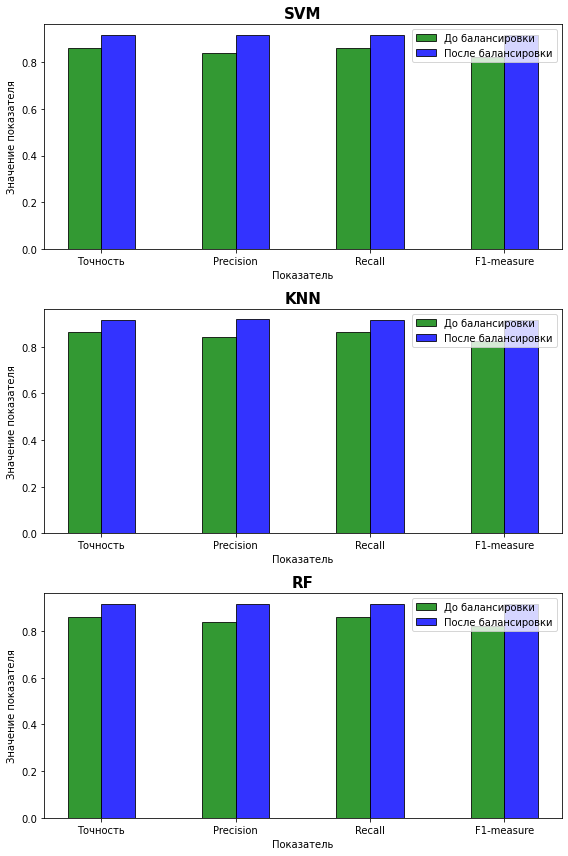

In [17]:
bar_width = 0.25
opacity = 0.8
fontsize = 10
keys = list(classifier_values['Before'].keys())

features_count = len(classifier_values['Before']['SVM']) # Количество признаков
classifieres_count = len(keys) # Количество классификаторов

fig, ax = plt.subplots(classifieres_count, figsize=(8,12))

color1 = []
ref_value = 0

for i in range(classifieres_count):
    index = np.arange(features_count)
    ax[i].bar(index, classifier_values['Before'][keys[i]], bar_width,
              alpha=opacity,
              color='g',
              label='До балансировки',
              edgecolor='black')
    
    ax[i].bar(index + bar_width, classifier_values['After'][keys[i]], bar_width,
              alpha=opacity,
              color='b',
              label='После балансировки',
              edgecolor='black')
    
    ax[i].set_xlabel('Показатель', fontsize = fontsize)
    ax[i].set_ylabel('Значение показателя', fontsize = fontsize)
    ax[i].set_xticks(index + (bar_width * 0.5))
    ax[i].set_xticklabels(('Точность', 'Precision', 'Recall', 'F1-measure'))
    ax[i].set_title(keys[i], fontsize=fontsize * 1.5, fontweight='bold')
    ax[i].legend(fontsize = fontsize)
    
plt.tight_layout()
plt.show()

# 3. Визуализация результатов классификации

In [18]:
def predict(cls):
    cls.fit(X_train_resampled, y_train_resampled)
    return cls.predict(X_test_resampled)

def create_plot(pred_values):
    import matplotlib.pyplot as plt
    colormap = np.array(['b', 'g', 'r', 'y'])

    _, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

    # UMAP
    import umap
    reducer = umap.UMAP()
    #Уменьшаем размерность данных
    X_test_2d = pd.DataFrame(reducer.fit_transform(X_test_resampled))
    
    ax1.scatter(X_test_2d[0], X_test_2d[1], c=colormap[y_test_resampled], alpha=0.1)
    ax1.set_title('Тестовые данные', fontsize=15, fontweight='bold')

    ax2.scatter(X_test_2d[0], X_test_2d[1], c=colormap[pred_values], alpha=0.1)
    ax2.set_title('Предсказанные данные', fontsize=15, fontweight='bold')

    # TSNE
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=0)

    #Уменьшаем размерность данных
    X_test_2d = pd.DataFrame(tsne.fit_transform(X_test_resampled))

    ax3.scatter(X_test_2d[0], X_test_2d[1], c=colormap[y_test_resampled], alpha=0.2)

    ax4.scatter(X_test_2d[0], X_test_2d[1], c=colormap[pred_values], alpha=0.2)

    plt.show()

## 3.1. SVM

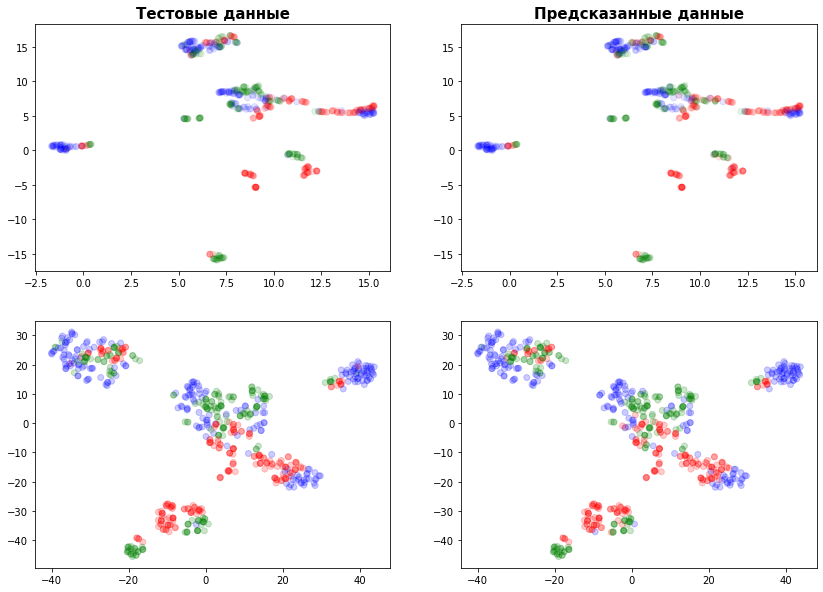

In [19]:
pred = predict(cls_a)
create_plot(pred)

## 3.2. KNN

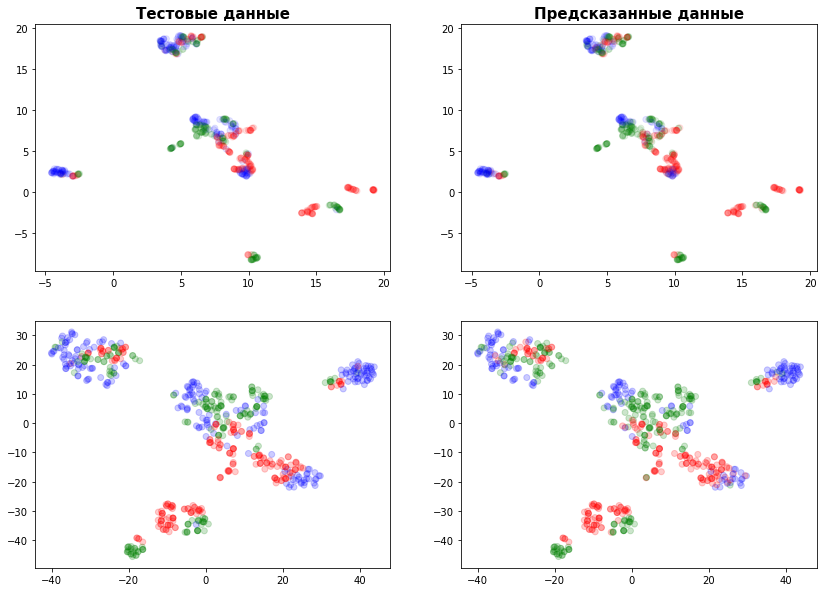

In [20]:
pred = predict(knn_a)
create_plot(pred)

## 3.3. RF

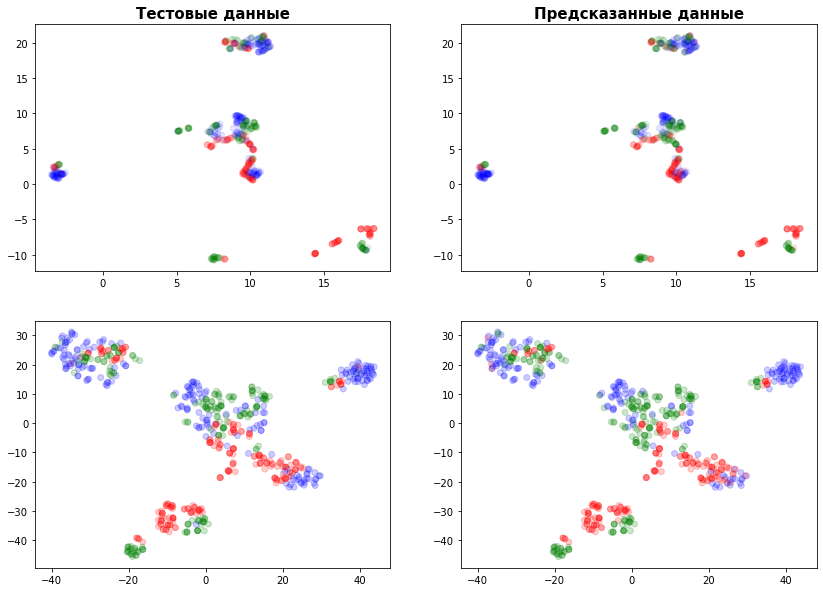

In [21]:
pred = predict(rf_a)
create_plot(pred)

# 4. Сравнение классификаторов на основе сбалансированных классов, обученных до балансировки

Данный пункт не был включен в задание, однако таким образом можно в полной мере показать полезность балансировки. Рассмотрим SVM-классификатор, обученный на несбалансированных классах, и поставим ему задачу предсказать значения сбалансированных классов (и наоборот).

In [22]:
# До балансировки
cls_b.fit(X_train, y_train)
# Данные после балансировки
pred = cls_b.predict(X_test_resampled)
    
print('До балансировки:')
print("\tОбщая точность: ", metrics.accuracy_score(y_test_resampled, y_pred=pred))
print("\tPrecision: ", metrics.precision_score(y_test_resampled, y_pred=pred, average='weighted'))
print("\tRecall: ", metrics.recall_score(y_test_resampled, y_pred=pred, average='weighted'))
print("\tF1-measure: ", metrics.f1_score(y_test_resampled, y_pred=pred, average='weighted'))
    
# После балансировки
cls_a.fit(X_train_resampled, y_train_resampled)
# Данные до балансировки
pred = cls_a.predict(X_test)
    
print('\nПосле балансировки:')    
print("\tОбщая точность: ", metrics.accuracy_score(y_test, y_pred=pred))
print("\tPrecision: ", metrics.precision_score(y_test, y_pred=pred, average='weighted'))
print("\tRecall: ", metrics.recall_score(y_test, y_pred=pred, average='weighted'))
print("\tF1-measure: ", metrics.f1_score(y_test, y_pred=pred, average='weighted'))

До балансировки:
	Общая точность:  0.47874015748031495
	Precision:  0.7205981149984217
	Recall:  0.47874015748031495
	F1-measure:  0.4082306483362578

После балансировки:
	Общая точность:  0.8870967741935484
	Precision:  0.8896183964469379
	Recall:  0.8870967741935484
	F1-measure:  0.8879610938005807


Теперь показатели "До балансировки" значительно ниже, чем в пункте **2.1**.
</br>Плохую обучаемость классификатора можно также продемонстрировать визуально на графике:

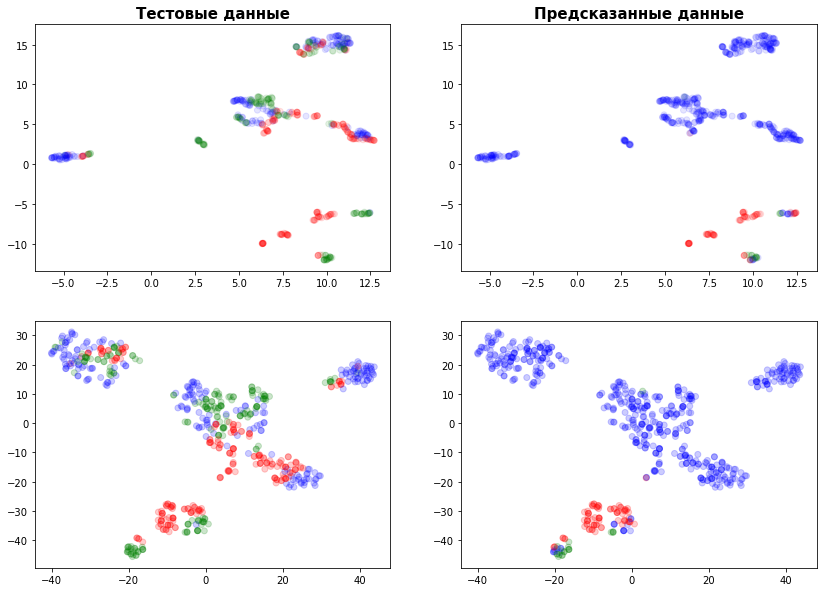

In [23]:
cls_b.fit(X_train, y_train)
pred = cls_b.predict(X_test_resampled)

create_plot(pred)